In [2]:
from shapely.geometry import Polygon,Point
from shapely import affinity
from math import tan,pi,cos,sin
import matplotlib.pyplot as plt
from ase.io import lammpsdata
import numpy as np
import sys
import ase.build as build

In [3]:
lmp_in_file_name = "./POSCAR.lmp"  # do not change this
HP = 0 #float(sys.argv[2])
sx = 2*17 #int(sys.argv[3])   # supercell along x factor
sy = 2*30 # int(sys.argv[4])   # supercell along y factor
lmp_out_file_name = "./POSCAR-test.lmp" # sys.argv[7]

np.random.seed(1)  # To reproduce the results

H_S_bl = 1.4  # Hydrogen-Sulfer bond length

lmp_data = lammpsdata.read_lammps_data(lmp_in_file_name,
                                       style="charge",
                                       units="real")

lmp_data = lmp_data*(sx, sy, 1)


atomic_positions = lmp_data.get_positions()
atomic_numbers = lmp_data.get_atomic_numbers()

S_positions = atomic_positions[np.where(atomic_numbers == 2)[0]]

S_no = S_positions.shape[0]  # Total number of Sulfer atoms

H_no = int(S_no*HP/100)  # We obtain the integer number

H_no_top = H_no//2
H_no_bot = H_no - H_no_top

S_positions_top = S_positions[S_positions[:, 2] > 10]
S_positions_bot = S_positions[S_positions[:, 2] < 10]

top_indicies = np.random.choice(
    S_positions_top.shape[0], H_no_top, replace=False)
bot_indicies = np.random.choice(
    S_positions_bot.shape[0], H_no_bot, replace=False)

# Now we are ready to add Hydrogen
for i in top_indicies:
    # Since if we specify H here then it will confuse with the atom type 1
    lmp_data.append("Li")
    lmp_data.positions[-1] = S_positions_top[i]+np.array([0, 0, H_S_bl])
for i in bot_indicies:
    lmp_data.append("Li")
    lmp_data.positions[-1] = S_positions_bot[i]+np.array([0, 0, -H_S_bl])
print(lmp_data.cell)

Cell([187.62678792587053, 191.16273046479193, 20.0])


0.2633974596215562


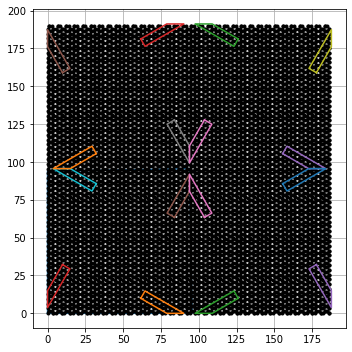

In [2]:
lx = lmp_data.cell[0,0]/2
ly = lmp_data.cell[1,1]/2
t = lx*0.1
lxp= lx - t
lyp= ly - t

tt = 2*t*0.3  # Fraction of t to cover while cutting
theta = 60 # deg
deg = pi/180.0
a = (lx - t * (1 + tan(theta*deg))) * cos(theta*deg) - t;
print(a/lx)

rect = Polygon(([0, 0], [0, lx], [lx, ly], [ly, 0]))
poly = Polygon(([0, 0-t], [tt, -t], [tt, a], [0, a]))
poly = affinity.translate(poly, -tt/2, 0, 0)

p1=affinity.translate(poly,lxp,0)
p1=affinity.rotate(p1,theta,origin=Point(lxp,0))
p1=p1.intersection(rect)

p2=affinity.translate(p1,t,lyp)
p2=affinity.rotate(p2,90,origin=Point(lx,lyp))

p3=affinity.translate(p1,-lxp+t,ly)
p3=affinity.rotate(p3,180,origin=Point(t,ly))

p4=affinity.translate(p1,-lxp,t)
p4=affinity.rotate(p4,270,origin=Point(0,t))

cuts=[p1,p2,p3,p4]
all_cuts=[]
for cut in cuts:
    all_cuts.append(cut)
    cut_r = affinity.scale(cut,-1,1,origin=Point(0,0))
    all_cuts.append(affinity.translate(cut_r,2*lx,0))
    cut_r = affinity.scale(cut,1,-1,origin=Point(0,0))
    all_cuts.append(affinity.translate(cut_r,0,2*ly))
    all_cuts.append(affinity.translate(cut,lx,ly))
    
plt.figure(figsize = (5,5))
plt.plot(*rect.exterior.xy)
plt.plot(lmp_data.get_positions()[:,0],lmp_data.get_positions()[:,1],".k")
for cut in all_cuts:
    plt.plot(*cut.exterior.xy)
plt.tight_layout()
plt.grid()
plt.savefig("./fig.svg")
plt.show()


In [3]:
def inside(pos):
    p=Point(pos[0],pos[1])
    for shape in all_cuts:
        if(shape.contains(p)):
            return True
    return False



In [4]:

lmp_data.set_initial_charges(lmp_data.get_initial_charges()*0.0)
lammpsdata.write_lammps_data("./POSCAR-uncut.lmp", lmp_data, atom_style="charge")
lmp_data_cut=lmp_data.copy()
del lmp_data_cut[[atom.index for atom in lmp_data_cut if inside(atom.position)]]
lammpsdata.write_lammps_data(lmp_out_file_name, lmp_data_cut, atom_style="charge")
data = open(lmp_out_file_name, "r+").readlines()
data[0] = f"Pristine 2H-MoS2 plus {HP}% Hydrogen\n"
open(lmp_out_file_name, "w").writelines(data)

